### Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Set Up

### Demographic

In [2]:
info = pd.read_excel('../data/Brain_networks/Demographic.xlsx')
info['Participant_ID'] = info['Participant_ID'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))

# Remove duplicates
info = info.drop_duplicates(subset='Participant_ID')

# Reset index (optional)
info = info.reset_index(drop=True)

# Display the result
info.head()

,Participant_ID,ADHD/NT,Gender
0,200,NT,F
1,201,ADHD,F
2,202,NT,F
3,205,NT,F
4,207,NT,F


### Define

In [3]:
condition_map = {
    'rsfMRI_HB6': 'rest',
    'flanker_events': 'task',
    'flanker_events_twitching': 'twitching'
}

exclude_cols = ['Participant_ID', 'Sequence_name', 'Condition_matfile', 'Condition', 'ADHD/NT', 'Gender']

In [4]:
significant_networks = pd.read_excel('significant_networks.xlsx')
significant_networks

,Feature,F-statistic,p-value,condition
0,Medial-Occipital,7.251092,0.009248,rest
1,Occipital-Lateral(L),6.771685,0.011737,rest
2,Medial-Lateral(L),26.535364,0.000003,task
3,Medial-Lateral(R),18.988989,0.000054,task
4,ACC-RPFC(L),5.479466,0.022701,task
5,AInsula(L)-RPFC(R),4.295991,0.042656,task
6,LPFC(L)-PPC(L),6.861821,0.011220,task


In [5]:
visual_features = ['Medial-Occipital', 'Occipital-Lateral(L)', 'Medial-Lateral(L)', 'Medial-Lateral(R)']
salience_features = ['ACC-RPFC(L)', 'AInsula(L)-RPFC(R)']
fp_features = ['LPFC(L)-PPC(L)']

# Random Forest

## Preprocess

### Visual

In [6]:
# Visual
visual_2021 = pd.read_excel('../data/Brain_networks/Network_CC/Visual_2021.xlsx')
visual_2022 = pd.read_excel('../data/Brain_networks/Network_CC/Visual_2022.xlsx')
visual_2023 = pd.read_excel('../data/Brain_networks/Network_CC/Visual_2023.xlsx')

all_visual = pd.concat([visual_2021, visual_2022, visual_2023], ignore_index=True)
all_visual.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC
0,200,rsfMRI_HB6,Condition001.mat,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010
1,201,rsfMRI_HB6,Condition001.mat,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031
2,202,rsfMRI_HB6,Condition001.mat,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582
3,205,rsfMRI_HB6,Condition001.mat,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152
4,207,rsfMRI_HB6,Condition001.mat,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045


In [7]:
visual_w_info = all_visual.merge(info, on='Participant_ID', how='inner')
matrix_visual = visual_w_info.drop(columns=['Condition_matfile', 'Sequence_name'], inplace=False)
matrix_visual.head()

,Participant_ID,Condition,Medial-Occipital,Medial-Lateral(L),Medial-Lateral(R),Occipital-Lateral(L),Occipital-Lateral(R),Lateral(L)-Lateral(R),Averaged_CC,ADHD/NT,Gender
0,200,rest,0.18123,0.22104,0.032202,0.68723,0.47970,0.97918,0.43010,NT,F
1,201,rest,0.44015,0.56515,0.427590,0.84800,0.88916,1.21180,0.73031,ADHD,F
2,202,rest,0.28081,0.21935,0.588840,0.51701,0.67580,0.87309,0.52582,NT,F
3,205,rest,0.39404,0.88638,0.519380,0.50584,0.28219,1.08130,0.61152,NT,F
4,207,rest,0.44657,0.32933,0.272310,0.47209,0.38130,0.68107,0.43045,NT,F


### Salience

In [8]:
# Salience
salience_2021 = pd.read_excel('../data/Brain_networks/Network_CC/Salience_2021.xlsx')
salience_2022 = pd.read_excel('../data/Brain_networks/Network_CC/Salience_2022.xlsx')
salience_2023 = pd.read_excel('../data/Brain_networks/Network_CC/Salience_2023.xlsx')

all_salience = pd.concat([salience_2021, salience_2022, salience_2023], ignore_index=True)
all_salience.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,ACC-AInsula(L),ACC-AInsula(R),ACC-RPFC(L),ACC-RPFC(R),ACC-SMG(L),ACC-SMG(R),...,AInsula(R)-RPFC(R),AInsula(R)-SMG(L),AInsula(R)-SMG(R),RPFC(L)-RPFC(R),RPFC(L)-SMG(L),RPFC(L)-SMG(R),RPFC(R)-SMG(L),RPFC(R)-SMG(R),SMG(L)-SMG(R),Averaged_CC
0,200,rsfMRI_HB6,Condition001.mat,rest,0.38244,0.42946,0.47293,0.68623,0.476520,0.147830,...,0.24826,0.40205,0.16082,0.51811,0.25721,0.083836,0.32207,0.010654,0.96934,0.34480
1,201,rsfMRI_HB6,Condition001.mat,rest,0.26701,0.30673,0.26035,0.47045,0.036738,0.296230,...,0.44240,0.13552,0.71314,0.79054,0.55826,0.608520,0.21384,0.581240,0.79743,0.49922
2,202,rsfMRI_HB6,Condition001.mat,rest,0.39955,0.76758,0.18989,0.30054,0.330140,0.064600,...,0.32921,0.48753,0.26006,0.42888,0.71127,0.337620,0.58176,0.955690,0.62045,0.39151
3,205,rsfMRI_HB6,Condition001.mat,rest,0.51393,0.60648,0.83598,0.76121,0.429540,-0.027161,...,0.64889,0.65663,0.22283,1.23650,0.55846,0.185300,0.59952,0.328870,0.55385,0.45836
4,207,rsfMRI_HB6,Condition001.mat,rest,0.50032,0.54461,0.35094,0.37688,0.286510,0.246030,...,0.32564,0.47198,0.62164,0.44331,0.75381,0.449490,0.38576,0.598050,0.79248,0.42589


In [9]:
salience_w_info = all_salience.merge(info, on='Participant_ID', how='inner')
matrix_salience = salience_w_info.drop(columns=['Condition_matfile', 'Sequence_name'], inplace=False)
matrix_salience.head()

,Participant_ID,Condition,ACC-AInsula(L),ACC-AInsula(R),ACC-RPFC(L),ACC-RPFC(R),ACC-SMG(L),ACC-SMG(R),AInsula(L)-AInsula(R),AInsula(L)-RPFC(L),...,AInsula(R)-SMG(R),RPFC(L)-RPFC(R),RPFC(L)-SMG(L),RPFC(L)-SMG(R),RPFC(R)-SMG(L),RPFC(R)-SMG(R),SMG(L)-SMG(R),Averaged_CC,ADHD/NT,Gender
0,200,rest,0.38244,0.42946,0.47293,0.68623,0.476520,0.147830,0.40015,0.63142,...,0.16082,0.51811,0.25721,0.083836,0.32207,0.010654,0.96934,0.34480,NT,F
1,201,rest,0.26701,0.30673,0.26035,0.47045,0.036738,0.296230,0.59892,0.81091,...,0.71314,0.79054,0.55826,0.608520,0.21384,0.581240,0.79743,0.49922,ADHD,F
2,202,rest,0.39955,0.76758,0.18989,0.30054,0.330140,0.064600,0.22255,0.55078,...,0.26006,0.42888,0.71127,0.337620,0.58176,0.955690,0.62045,0.39151,NT,F
3,205,rest,0.51393,0.60648,0.83598,0.76121,0.429540,-0.027161,0.41983,0.29928,...,0.22283,1.23650,0.55846,0.185300,0.59952,0.328870,0.55385,0.45836,NT,F
4,207,rest,0.50032,0.54461,0.35094,0.37688,0.286510,0.246030,0.63985,0.32830,...,0.62164,0.44331,0.75381,0.449490,0.38576,0.598050,0.79248,0.42589,NT,F


### FP

In [10]:
# FrontoParietal
fp_2021 = pd.read_excel('../data/Brain_networks/Network_CC/FP_2021.xlsx')
fp_2022 = pd.read_excel('../data/Brain_networks/Network_CC/FP_2022.xlsx')
fp_2023 = pd.read_excel('../data/Brain_networks/Network_CC/FP_2023.xlsx')

all_fp = pd.concat([fp_2021, fp_2022, fp_2023], ignore_index=True)
all_fp.head()

,Participant_ID,Sequence_name,Condition_matfile,Condition,LPFC(L)-PPC(L),LPFC(L)-LPFC(R),LPFC(L)-PPC(R),PPC(L)-LPFC(R),PPC(L)-PPC(R),LPFC(R)-PPC(R),Averaged_CC
0,200,rsfMRI_HB6,Condition001.mat,rest,0.74405,0.31677,0.07744,0.42630,0.42652,0.98033,0.49524
1,201,rsfMRI_HB6,Condition001.mat,rest,0.80099,0.17939,0.31250,0.07402,0.68910,0.61432,0.44505
2,202,rsfMRI_HB6,Condition001.mat,rest,1.21860,0.74083,0.52707,0.73794,0.64482,1.09550,0.82746
3,205,rsfMRI_HB6,Condition001.mat,rest,0.65107,0.79147,0.15068,0.82202,0.68807,0.54380,0.60785
4,207,rsfMRI_HB6,Condition001.mat,rest,0.75497,0.39063,0.45857,0.73926,0.70244,1.07230,0.68636


In [11]:
fp_w_info = all_fp.merge(info, on='Participant_ID', how='inner')
matrix_fp = fp_w_info.drop(columns=['Condition_matfile', 'Sequence_name'], inplace=False)
matrix_fp.head()

,Participant_ID,Condition,LPFC(L)-PPC(L),LPFC(L)-LPFC(R),LPFC(L)-PPC(R),PPC(L)-LPFC(R),PPC(L)-PPC(R),LPFC(R)-PPC(R),Averaged_CC,ADHD/NT,Gender
0,200,rest,0.74405,0.31677,0.07744,0.42630,0.42652,0.98033,0.49524,NT,F
1,201,rest,0.80099,0.17939,0.31250,0.07402,0.68910,0.61432,0.44505,ADHD,F
2,202,rest,1.21860,0.74083,0.52707,0.73794,0.64482,1.09550,0.82746,NT,F
3,205,rest,0.65107,0.79147,0.15068,0.82202,0.68807,0.54380,0.60785,NT,F
4,207,rest,0.75497,0.39063,0.45857,0.73926,0.70244,1.07230,0.68636,NT,F


## Feature extraction

In [14]:
X_visual = matrix_visual[visual_features]
X_salience = matrix_salience[salience_features]
X_fp = matrix_fp[fp_features]

In [15]:
y_visual = matrix_visual['ADHD/NT'].map({'NT': 0, 'ADHD': 1})
y_salience = matrix_salience['ADHD/NT'].map({'NT': 0, 'ADHD': 1})
y_fp = matrix_fp['ADHD/NT'].map({'NT': 0, 'ADHD': 1})

## Function

In [27]:
def run_rf_analysis(X, y, network_name='Network'):
    print(f"\n=== Analyzing {network_name} ===")
    
    # 1. Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2. Model
    model = RandomForestClassifier(random_state=42, n_estimators=100)
    
    # 3. Cross-validation (Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Accuracy
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    print(f"Cross-validated Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")
    
    # AUC
    y_proba = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
    auc = roc_auc_score(y, y_proba)
    print(f"AUC-ROC Score: {auc:.3f}")
    
    # Classification Report (train on full data for interpretability)
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    print("\nClassification Report (on full data):")
    print(classification_report(y, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{network_name} Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

    # 4. Feature Importance
    importances = model.feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure()
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'{network_name} - Feature Importance')
    plt.tight_layout()
    plt.show()



=== Analyzing Visual Network ===
Cross-validated Accuracy: 0.631 ± 0.043
AUC-ROC Score: 0.686

Classification Report (on full data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       108

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168



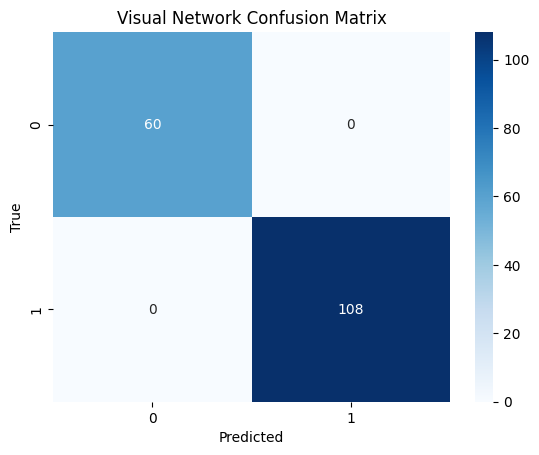

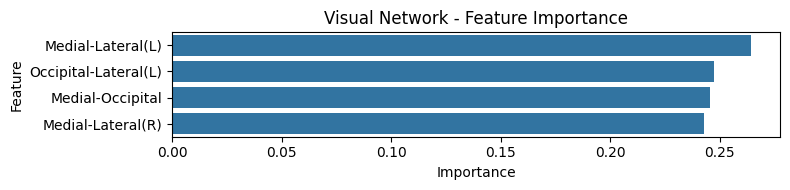

In [24]:
# Visual Network
run_rf_analysis(X_visual, y_visual, network_name='Visual Network')



=== Analyzing Salience Network ===
Cross-validated Accuracy: 0.571 ± 0.011
AUC-ROC Score: 0.554

Classification Report (on full data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       108

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168



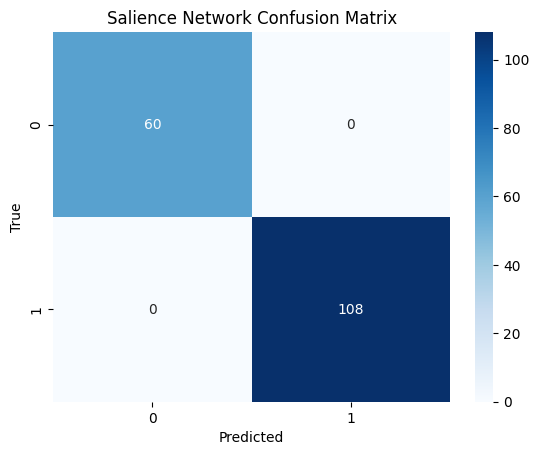

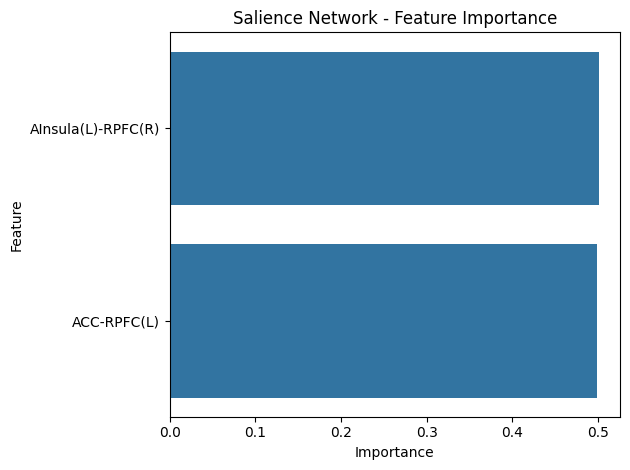

In [28]:
# Salience Network
run_rf_analysis(X_salience, y_salience, network_name='Salience Network')


=== Analyzing Central Executive Network ===
Cross-validated Accuracy: 0.625 ± 0.080
AUC-ROC Score: 0.610

Classification Report (on full data):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.99      1.00      1.00       108

    accuracy                           0.99       168
   macro avg       1.00      0.99      0.99       168
weighted avg       0.99      0.99      0.99       168



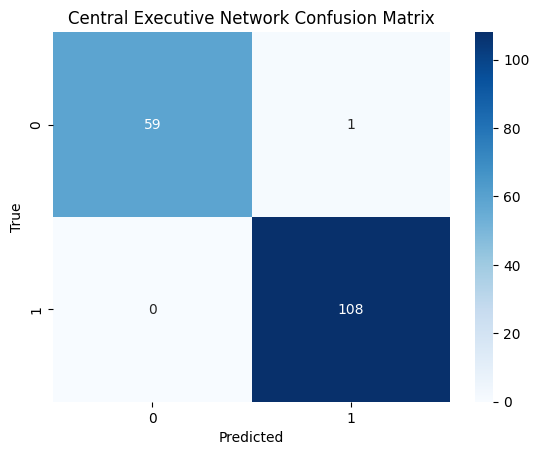

/var/folders/x2/p4tywwxn5bvcgmwb3s6kshl80000gn/T/ipykernel_41138/59281739.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


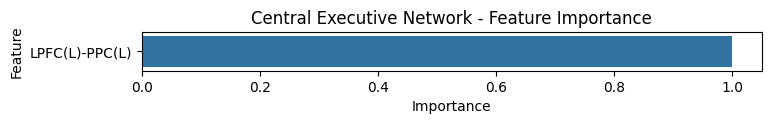

In [26]:
# Central Executive / Frontoparietal Network
run_rf_analysis(X_fp, y_fp, network_name='Central Executive Network')